In [ ]:
import torch
import torchview
import torchvision as tv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [6]:
train_dataset = tv.datasets.MNIST(root="/home/zorinep/big_data_magistracy/data_analysis/lessons", train=True, transform=tv.transforms.ToTensor())
test_dataset = tv.datasets.MNIST(root="/home/zorinep/big_data_magistracy/data_analysis/lessons", train=False, transform=tv.transforms.ToTensor())

batch_size=64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [16]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=8, out_channels=32, kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=36864, out_features=10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
def calc_accuracy(y_pred, y_true):
    return sum(y_true.numpy() == np.array([torch.argmax(i).item() for i in y_pred])) / len(np.array([torch.argmax(i).item() for i in y_pred]))

In [18]:
epoches = 5

train_loss = []
train_accuracy = []
test_accuracy = []

max_train_acc = -float("inf")

for e in range(epoches):
    train_progress = tqdm(train_loader)
    model.train()

    running_train_loss = []
    running_train_accuracy = []
    for x, y in train_progress:
        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        acc = float(calc_accuracy(y_pred=y_pred, y_true=y))
        loss.backward()

        optimizer.step()

        running_train_loss.append(loss.item())
        running_train_accuracy.append(acc)

        train_progress.set_description(f"TRAIN [{e+1}/{epoches}] accuracy={acc:.3f} loss={loss.item():.3f}")
    train_loss.append(np.mean(running_train_loss))
    train_accuracy.append(np.mean(running_train_accuracy))

with torch.no_grad():
    model.eval()

    test_progress = tqdm(test_loader)
    running_test_accuracy = []
    for x, y in test_progress:
        y_pred = model(x)
        acc = float(calc_accuracy(y_pred=y_pred, y_true=y))
        running_test_accuracy.append(acc)

        test_progress.set_description(f"TEST  [{e+1}/{epoches}] accuracy={acc:.3f}")

        if acc > max_train_acc:
            max_train_acc = acc
            torch.save(model.state_dict(), "best.pt")

    test_accuracy.append(np.mean(running_test_accuracy))

TEST  [5/5] accuracy=1.000: 100%|██████████| 157/157 [00:04<00:00, 36.27it/s]


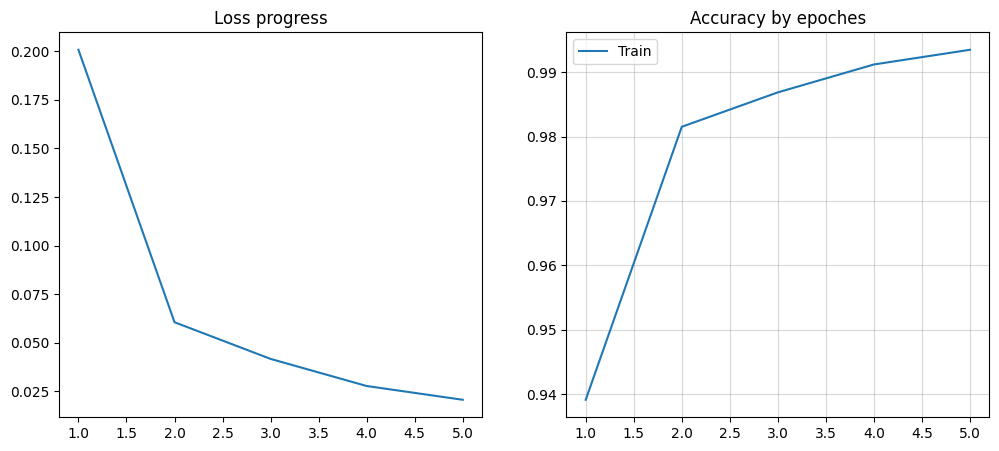

In [22]:
fix, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot([i for i in range(1, len(train_loss)+1)], train_loss)
ax[0].set_title("Loss progress")
ax[1].plot([i for i in range(1, len(train_accuracy)+1)], train_accuracy, label="Train")
ax[1].set_title("Accuracy by epoches")
plt.grid(alpha=0.5)
plt.legend()
plt.show()